In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
dataset_path = "E:/FeatherFarmSoloutions/dataset"
csv_path = os.path.join(dataset_path, "train_data.csv")
image_folder = os.path.join(dataset_path, "Train")

In [3]:
df = pd.read_csv(csv_path)
print("Dataset Info:")
print(df.head())

Dataset Info:
           images               label
0  salmo.1558.jpg          Salmonella
1  cocci.1866.jpg         Coccidiosis
2   cocci.171.jpg         Coccidiosis
3  salmo.1484.jpg          Salmonella
4     ncd.100.jpg  New Castle Disease


In [4]:
print("\nLabel Distribution:")
print(df['label'].value_counts())


Label Distribution:
label
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: count, dtype: int64


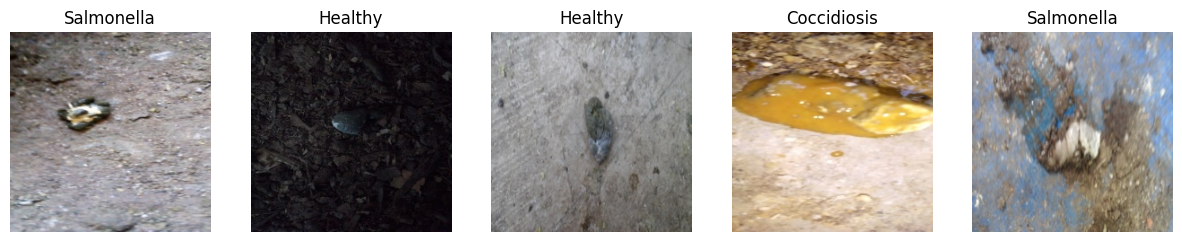

In [5]:
# Visualize sample images
def show_sample_images(df, image_folder, num_samples=5):
    sample = df.sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (index, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(image_folder, row['images'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(row['label'])
        axes[i].axis('off')
    plt.show()

show_sample_images(df, image_folder)

In [8]:
def preprocess_images(df, image_folder, img_size=(128, 128)):
    for index, row in df.iterrows():
        img_path = os.path.join(image_folder, row['images'])
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0  # Convert to float32 and normalize
        yield img, row['label']  # Yield image one by one instead of storing all in RAM

In [9]:
# Load images and labels
image_gen = preprocess_images(df, image_folder)

In [10]:
# Convert generator to list (batch by batch, not all at once)
X, y = zip(*list(image_gen))  # Convert generator output to lists
X = np.array(X)  # Convert list to NumPy array
y = np.array(y)

print("Loaded dataset successfully!")

Loaded dataset successfully!


In [11]:
# Convert labels to numerical format
unique_labels = sorted(set(y))  # Use set() to get unique labels
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_map[label] for label in y])  # Map labels to numbers


In [12]:
# Split dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [13]:
# Convert labels to categorical format
num_classes = len(unique_labels)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [14]:
print("\nDataset Split Complete:")
print(f"Train size: {len(X_train)} | Validation size: {len(X_val)} | Test size: {len(X_test)}")


Dataset Split Complete:
Train size: 5807 | Validation size: 646 | Test size: 1614


In [15]:
#TRAIN THE CNN

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [25]:
# Define CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),  # Fix warning
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [26]:
# Initialize model
input_shape = (128, 128, 3)  # Use (128, 128) to reduce memory usage
num_classes = len(unique_labels)
model = create_cnn_model(input_shape, num_classes)

In [27]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
# Define callbacks
checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20, batch_size=32,
                    callbacks=[checkpoint, early_stop])

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.4927 - loss: 1.5296 

182/182 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.4934 - loss: 1.5269 - val_accuracy: 0.7941 - val_loss: 0.6086
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7553 - loss: 0.6964 

182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.7554 - loss: 0.6962 - val_accuracy: 0.7988 - val_loss: 0.5826
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7879 - loss: 0.6016 

182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.7880 - loss: 0.6015 - val_accuracy: 0.8158 - val_loss: 0.5012
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8184 - loss: 0.5097 

182/182 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.8184 - loss: 0.5097 - val_accuracy: 0.8313 - val_loss: 0.4981
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8397 - loss: 0.4567 

182/182 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 0.8396 - loss: 0.4567 - val_accuracy: 0.8375 - val_loss: 0.4530
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8565 - loss: 0.4133 

182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step - accuracy: 0.8565 - loss: 0.4133 - val_accuracy: 0.8406 - val_loss: 0.4823
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8791 - loss: 0.3561 

182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.8791 - loss: 0.3561 - val_accuracy: 0.8545 - val_loss: 0.4273
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8905 - loss: 0.3113 

182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.8905 - loss: 0.3113 - val_accuracy: 0.8622 - val_loss: 0.4267
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9101 - loss: 0.2626 

182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 178ms/step - accuracy: 0.9101 - loss: 0.2626 - val_accuracy: 0.8762 - val_loss: 0.4005
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - accuracy: 0.9258 - loss: 0.2268 - val_accuracy: 0.8669 - val_loss: 0.4316
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 174ms/step - accuracy: 0.9384 - loss: 0.1766 - val_accuracy: 0.8375 - val_loss: 0.4764
Epoch 12/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 175ms/step - accuracy: 0.9381 - loss: 0.1874 - val_accuracy: 0.8700 - val_loss: 0.4979
Epoch 13/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.9546 - loss: 0.1376 - val_accuracy: 0.8700 - val_loss: 0.4524
Epoch 14/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.9649 - loss: 0.1229 - val_accuracy: 0.8638 - val_loss: 0.4552


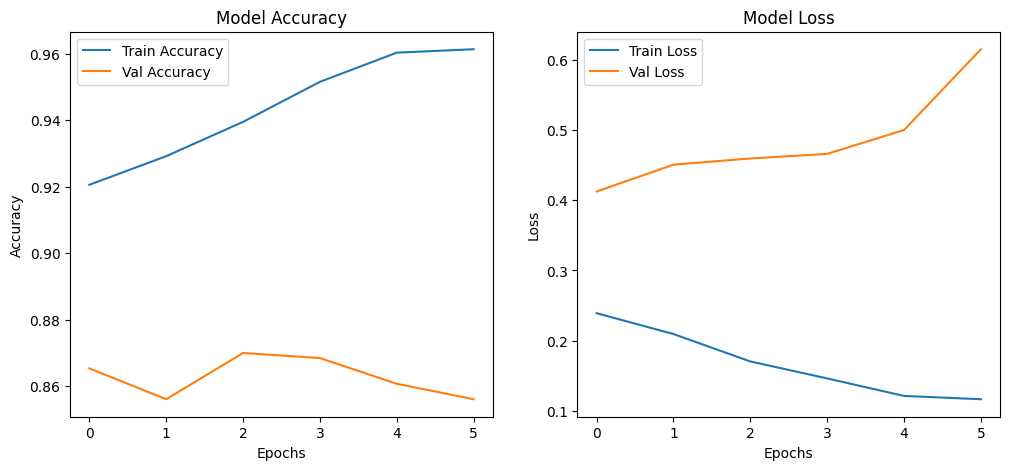

In [31]:
# Plot accuracy and loss curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    
    plt.show()

plot_learning_curves(history)

In [32]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8636 - loss: 0.4329
Test Accuracy: 86.12%


In [33]:
#ENSEMBLE LEARNING

In [44]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import accuracy_score

In [35]:
# Load trained CNN model
cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.load_weights('best_cnn_model.h5')

In [36]:
# Define Transfer Learning model (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 20s 2us/step


In [37]:
# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(num_classes, activation='softmax')(x)

In [38]:
# Build MobileNetV2 model
mobilenet_model = Model(inputs=base_model.input, outputs=out)

In [39]:
# Compile MobileNetV2 model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [40]:
# Train MobileNetV2 model
mobilenet_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20, batch_size=32,
                    callbacks=[checkpoint, early_stop])

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 44s 208ms/step - accuracy: 0.7341 - loss: 0.7052 - val_accuracy: 0.8715 - val_loss: 0.3718
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - accuracy: 0.8704 - loss: 0.3669 - val_accuracy: 0.8700 - val_loss: 0.3771
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8885 - loss: 0.3074 

182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.8885 - loss: 0.3073 - val_accuracy: 0.8932 - val_loss: 0.3155
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9083 - loss: 0.2569 

182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.9084 - loss: 0.2569 - val_accuracy: 0.9071 - val_loss: 0.2898
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.9235 - loss: 0.2192 - val_accuracy: 0.9071 - val_loss: 0.2799
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.9329 - loss: 0.1943 - val_accuracy: 0.8978 - val_loss: 0.2834
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.9344 - loss: 0.1762 - val_accuracy: 0.9025 - val_loss: 0.3134
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9366 - loss: 0.1756 

182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.9366 - loss: 0.1756 - val_accuracy: 0.9180 - val_loss: 0.2623
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.9421 - loss: 0.1540 - val_accuracy: 0.9164 - val_loss: 0.2673
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - accuracy: 0.9471 - loss: 0.1383 - val_accuracy: 0.9102 - val_loss: 0.3088
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - accuracy: 0.9507 - loss: 0.1420 - val_accuracy: 0.9180 - val_loss: 0.2730
Epoch 12/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9481 - loss: 0.1353 

182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 155ms/step - accuracy: 0.9481 - loss: 0.1352 - val_accuracy: 0.9272 - val_loss: 0.2572
Epoch 13/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 144ms/step - accuracy: 0.9636 - loss: 0.1057 - val_accuracy: 0.9241 - val_loss: 0.2719
Epoch 14/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - accuracy: 0.9597 - loss: 0.1081 - val_accuracy: 0.9164 - val_loss: 0.2822
Epoch 15/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - accuracy: 0.9607 - loss: 0.1074 - val_accuracy: 0.9180 - val_loss: 0.2978
Epoch 16/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - accuracy: 0.9668 - loss: 0.0908 - val_accuracy: 0.9226 - val_loss: 0.2872
Epoch 17/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - accuracy: 0.9668 - loss: 0.0931 - val_accuracy: 0.9149 - val_loss: 0.3223


In [46]:
mobilenet_model.save('mobilenet_model.h5')

In [41]:
# Evaluate both models
cnn_preds = cnn_model.predict(X_test)
mobilenet_preds = mobilenet_model.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step


In [42]:
# Ensemble Model: Averaging Predictions
ensemble_preds = (cnn_preds + mobilenet_preds) / 2
ensemble_labels = np.argmax(ensemble_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

In [45]:
# Calculate Ensemble Accuracy
ensemble_acc = accuracy_score(y_true, ensemble_labels)
print(f"Ensemble Model Accuracy: {ensemble_acc * 100:.2f}%")

Ensemble Model Accuracy: 92.07%
